In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# 1. Data loading, data cleaning & data validation

there are 3 datasets from ECI website are provided for this analysis project
- `constituency_wise_results_2014.csv`
- `constituency_wise_results_2019.csv`
- `dim_states_codes.csv`

Note :
- we are not using dim_states_codes because we have been provided state name and their abbreviation in this dataset, but we are using full name for state that's why we don't need to load it to.

In [2]:
# importing data
dt_2014 = pd.read_csv("datasets/constituency_wise_results_2014.csv")
dt_2019 = pd.read_csv("datasets/constituency_wise_results_2019.csv")

In [3]:
# check samples of 2014 results dataset
dt_2014.sample(3)

,state,pc_name,candidate,sex,age,category,party,party_symbol,general_votes,postal_votes,total_votes,total_electors
3472,Maharashtra,Buldhana,None of the Above,NaN,NaN,NaN,NOTA,NOTA,10546,0,10546,1595435
7460,West Bengal,Dum dum,None of the Above,NaN,NaN,NaN,NOTA,NOTA,16769,68,16837,1405981
6302,Uttar Pradesh,Pilibhit,None of the Above,NaN,NaN,NaN,NOTA,NOTA,11519,2,11521,1671154


In [4]:
# check samples of 2019 results dataset
dt_2019.sample(3)

,state,pc_name,candidate,sex,age,category,party,party_symbol,general_votes,postal_votes,total_votes,total_electors
1689,Haryana,Karnal,Sanjay Bhatia,MALE,51.0,GENERAL,BJP,Lotus,909432,2162,911594,1904193
8433,NCT OF Delhi,NORTH EAST DELHI,ABHINAV KUMAR,MALE,32.0,GENERAL,SANVP,Refrigerator,309,0,309,2290492
8278,Telangana,Warangal,BOLLAPALLY SARAIAH,MALE,60.0,SC,BSP,Elephant,8183,10,8193,1666770


### Cleaning data 

In [5]:
# we are mostly going to work on pc_name so we are checking data of this column to identify any bad data.
dt_2014.pc_name.unique()

array(['Adilabad ', 'Peddapalle ', 'Karimnagar ', 'Nizamabad',
       'Zahirabad', 'Medak', 'Malkajgiri', 'Secundrabad', 'Hyderabad',
       'CHELVELLA', 'Mahbubnagar', 'Nagarkurnool', 'Nalgonda', 'Bhongir ',
       'Warangal', 'Mahabubabad  ', 'Khammam ', 'Aruku ', 'Srikakulam',
       'Vizianagaram', 'Visakhapatnam', 'Anakapalli', 'Kakinada',
       'Amalapuram ', 'Rajahmundry', 'Narsapuram', 'Eluru ',
       'Machilipatnam ', 'Vijayawada', 'Guntur', 'Narasaraopet',
       'Bapatla ', 'Ongole ', 'Nandyal', 'Kurnool', 'Anantapur',
       'Hindupur', 'Kadapa', 'Nellore', 'Tirupati ', 'Rajampet',
       'Chittoor ', 'ARUNACHAL WEST', 'ARUNACHAL EAST', 'Karimganj ',
       'Silchar', 'Autonomous District', 'Dhubri', 'Kokrajhar', 'Barpeta',
       'Gauhati', 'Mangaldoi', 'Tezpur', 'Nowgong', 'Kaliabor', 'Jorhat',
       'Dibrugarh', 'Lakhimpur', 'Valmiki Nagar', 'Paschim Champaran',
       'Purvi Champaran', 'Sheohar', 'Sitamarhi', 'Madhubani',
       'Jhanjharpur', 'Supaul', 'Araria', 'K

Obesrvations:
1. There are extra trailing spaces
2. Few reserved constituencies have (SC) mentioned in their name which is not required for our analysis
3. Few pc_names are in title case while rest are in capital case.
4. There is '-' in between few pc_names.

In [6]:
# function to clean above data errors
def cleaner(name):
    
    # for converting names to lower case
    name = name.lower()

    # to remove "(sc)" from names
    name = name.replace("(sc)","")

    # to replace "-" with space in names
    name = name.replace(" - "," ")
    name = name.replace("-"," ")

    # removing extra spaces from names
    name = name.strip()

    # returing the proper name
    return name

In [7]:
# applying cleaner to remove all errors  
dt_2014.pc_name = dt_2014.pc_name.apply(lambda x : cleaner(x))
dt_2019.pc_name = dt_2019.pc_name.apply(lambda x : cleaner(x))

### Now we are looking for incorrect spelling in pc_name
Note:
- we are finding mistakes from data of 2014 because in 2014 we don't have data of Odisha and Chhattisgarh.

In [8]:
# verify if the pc_names in 2014 dataset are present in 2019 dataset
[x for x in dt_2014.pc_name.unique() if x not in dt_2019.pc_name.unique()]

['chelvella', 'joynagar', 'burdwan durgapur', 'dadar & nagar haveli']

These 4 pc_names have spelling mistakes
- I used excel to identify the correct spellings

In [9]:
# replace incorrect pc_names with correct spellings
canges_for_2014 = {"chelvella": "chevella",
                    "joynagar": "jaynagar",
                    "burdwan durgapur": "bardhaman durgapur",
                    "dadar & nagar haveli": "dadra and nagar haveli"}

In [10]:
dt_2014.pc_name.replace(canges_for_2014, inplace = True)

### As we were told that some constituencies has to be part of telangana.

In [11]:
# list of constituencies which belongs to telangana state in 2019 dataset
Telangana_pc_name = dt_2019[dt_2019.state == "Telangana"].pc_name.unique()

In [12]:
# function to change those names
def replacer(row):
    if row.pc_name in Telangana_pc_name:
        return row.state.replace(row.state , "Telangana")
    else:
        return row.state

In [13]:
# appling that function on data
dt_2014.state = dt_2014.apply(replacer,axis = 1)

### In this data there are some constituencies which has 2 states so in this section we are going to label them with their states

In [14]:
# funtion to add constituencie name with there city.
def data_corrector(dataframe):
    dataframe["pc_name"] = np.where((dataframe["state"] == "Himachal Pradesh") & (dataframe["pc_name"] == "hamirpur"), "hamirpur (Himachal Pradesh)",
    np.where((dataframe["state"] == "Bihar") & (dataframe["pc_name"] == "aurangabad"), "aurangabad (Bihar)",
    np.where((dataframe["state"] == "Bihar") & (dataframe["pc_name"] == "maharajganj"), "maharajganj (Bihar)",
    np.where((dataframe["state"] == "Uttar Prades") & (dataframe["pc_name"] == "hamirpur"), "hamirpur (Uttar Prades)",
    np.where((dataframe["state"] == "Uttar Prades") & (dataframe["pc_name"] == "maharajganj"), "maharajganj (Uttar Prades)",
    np.where((dataframe["state"] == "Maharashtra") & (dataframe["pc_name"] == "aurangabad"), "aurangabad (Maharashtra)",dataframe["pc_name"]))))))

In [15]:
# applying function to the data set.
data_corrector(dt_2014)
data_corrector(dt_2019)

### In 2019 we have blank party symbol for NOTA so we are doing NOTA on its place same as in 2014

In [16]:
# replacing blank symbol in NOTA with NOTA.
dt_2019.loc[(dt_2019['party'] == "NOTA"), 'party_symbol'] = 'NOTA'

### Some parties have different symbols so this section is to resolve this problem

In [17]:
# joining party symbols with party.
dt_2014.party = (dt_2014.party + " , " + dt_2014.party_symbol)
dt_2019.party = (dt_2019.party + " , " + dt_2019.party_symbol)

# statistical info

In [18]:
# statistical info from numerical columns
dt_2014.describe()

,age,general_votes,postal_votes,total_votes,total_electors
count,7845.000000,8355.000000,8355.000000,8355.000000,8.355000e+03
mean,47.135883,62132.985398,107.407660,62240.393058,1.574132e+06
std,11.902487,140261.650370,436.090305,140535.827087,2.711797e+05
min,25.000000,105.000000,0.000000,105.000000,4.992200e+04
25%,38.000000,1708.000000,0.000000,1708.500000,1.446478e+06
50%,46.000000,4350.000000,1.000000,4354.000000,1.578125e+06
75%,56.000000,14881.000000,13.000000,14886.000000,1.718414e+06
max,93.000000,859973.000000,6792.000000,863358.000000,3.183083e+06


In [19]:
# statistical info from numerical columns
dt_2019.describe()

,age,general_votes,postal_votes,total_votes,total_electors
count,8054.000000,8.597000e+03,8597.000000,8.597000e+03,8.597000e+03
mean,47.065185,7.117290e+04,267.469699,7.144037e+04,1.705181e+06
std,12.140434,1.735669e+05,929.319680,1.742342e+05,2.969405e+05
min,24.000000,8.400000e+01,0.000000,8.400000e+01,5.518900e+04
25%,38.000000,1.315000e+03,1.000000,1.317000e+03,1.553385e+06
50%,46.000000,3.341000e+03,4.000000,3.350000e+03,1.703279e+06
75%,56.000000,1.239100e+04,36.000000,1.242100e+04,1.856791e+06
max,90.000000,1.066824e+06,19367.000000,1.068569e+06,3.150313e+06


# 2. Primary Questions

### Q 1. List top 5/ bottom 5 constituencies of 2014 and 2019 in terms of voter turnout ratio

Top 5 constituencies of 2014

In [20]:
group = dt_2014.groupby("pc_name")
temp_df1 = group["total_votes"].sum().to_frame()
temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()
df = pd.merge(temp_df1,temp_df2, on = "pc_name")
df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100,2)

In [21]:
data = df.sort_values("Turnout Ratio",ascending = False).head(5)
data

,total_votes,total_electors,Turnout Ratio
pc_name,,,
dhubri,1369624,1550166,88.35
nagaland,1038910,1182972,87.82
tamluk,1337684,1527273,87.59
bishnupur,1272070,1466921,86.72
lakshadweep,43239,49922,86.61


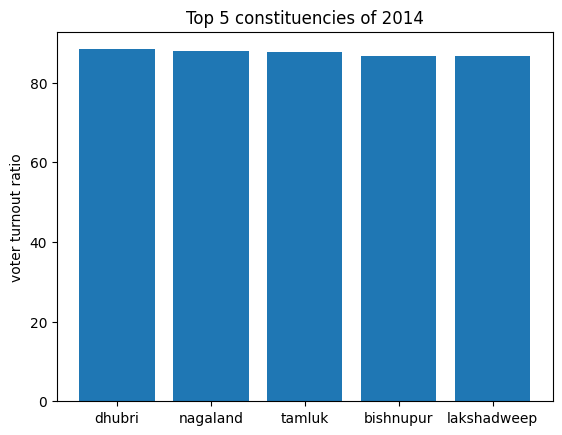

In [22]:
plt.bar(data.index,data["Turnout Ratio"])
plt.title("Top 5 constituencies of 2014")
plt.ylabel("voter turnout ratio")
plt.show()

Bottom 5 constituencies of 2014

In [23]:
data = df.sort_values("Turnout Ratio").head(5)
data

,total_votes,total_electors,Turnout Ratio
pc_name,,,
srinagar,312212,1207230,25.86
anantnag,375279,1301143,28.84
baramulla,465992,1190766,39.13
kalyan,824196,1922034,42.88
patna sahib,882262,1946249,45.33


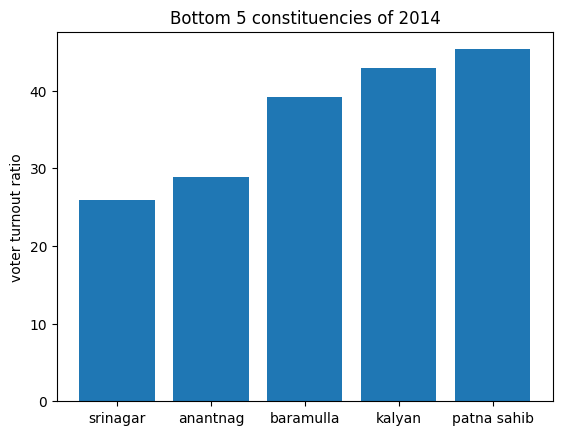

In [24]:
plt.bar(data.index,data["Turnout Ratio"])
plt.title("Bottom 5 constituencies of 2014")
plt.ylabel("voter turnout ratio")
plt.show()

Top 5 constituencies of 2019

In [25]:
group = dt_2019.groupby("pc_name")
temp_df1 = group["total_votes"].sum().to_frame()
temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()
df = pd.merge(temp_df1,temp_df2, on = "pc_name")
df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100,2)

In [26]:
data = df.sort_values("Turnout Ratio",ascending = False).head(5)
data

,total_votes,total_electors,Turnout Ratio
pc_name,,,
dhubri,1685005,1858566,90.66
bishnupur,1420648,1627199,87.31
barpeta,1458549,1685149,86.55
jalpaiguri,1500922,1735464,86.49
arunachal east,293781,339788,86.46


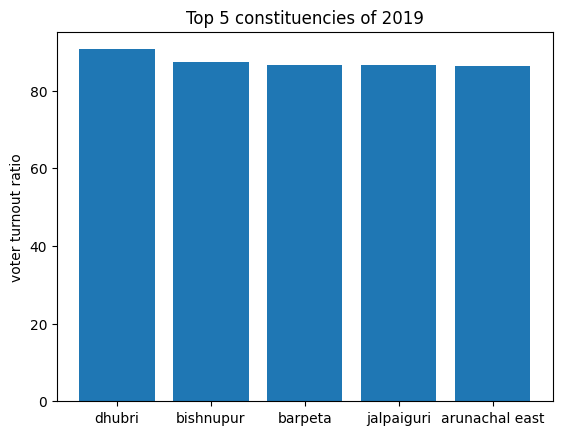

In [27]:
plt.bar(data.index,data["Turnout Ratio"])
plt.title("Top 5 constituencies of 2019")
plt.ylabel("voter turnout ratio")
plt.show()

Bottom 5 constituencies of 2019

In [28]:
data = df.sort_values("Turnout Ratio").head(5)
data

,total_votes,total_electors,Turnout Ratio
pc_name,,,
anantnag,124896,1397779,8.94
srinagar,186832,1294671,14.43
baramulla,455550,1317738,34.57
hyderabad,877872,1957931,44.84
kalyan,890313,1965676,45.29


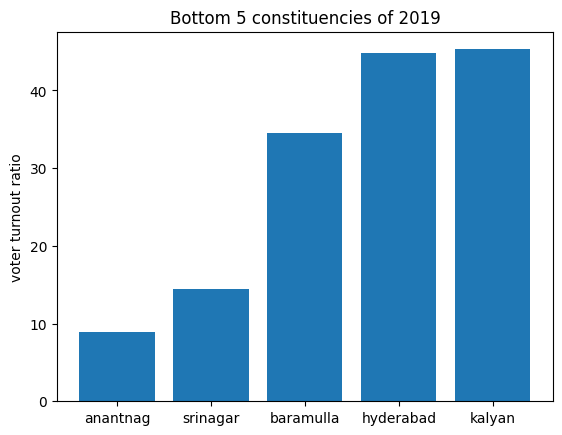

In [29]:
plt.bar(data.index,data["Turnout Ratio"])
plt.title("Bottom 5 constituencies of 2019")
plt.ylabel("voter turnout ratio")
plt.show()

### Q 2. List top 5/ bottom 5 states of 2014 and 2019 in terms of voter turnout ratio

#### Analysis of 2014

In [30]:
group = dt_2014.groupby("pc_name")
temp_df1 = group["total_votes"].sum().to_frame()
temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()
temp_df3 = group["state"].apply(lambda x: x.unique()[0]).to_frame()
df = pd.merge(temp_df1,temp_df2, on = "pc_name")
df = pd.merge(df,temp_df3, on = "pc_name")
df.set_index("state", inplace = True)
df = df.groupby("state").sum()
df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100,2)

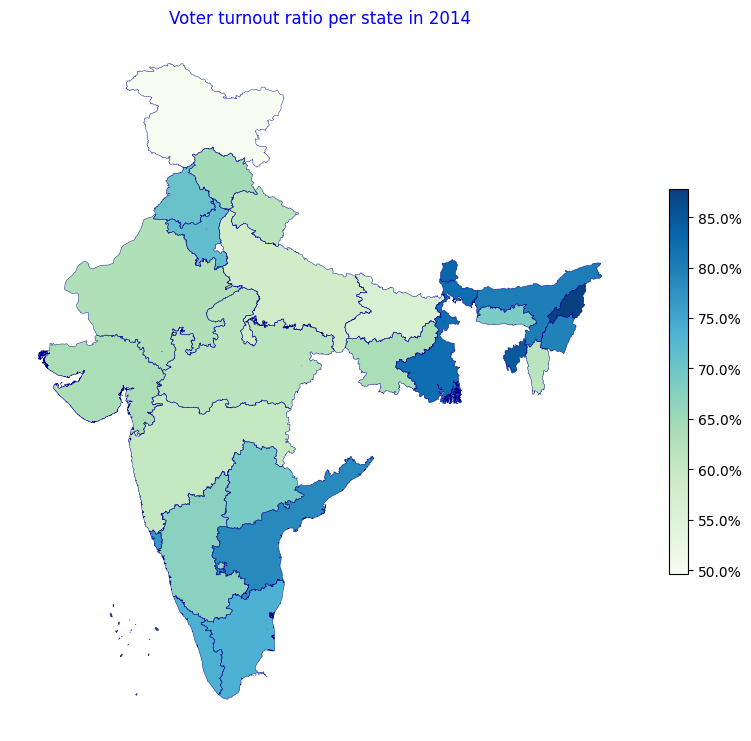

In [31]:
state_shape = gpd.read_file("states_shape/Indian_States.shp")
state_data = pd.DataFrame({"state": df.index,"tr":df["Turnout Ratio"]}).reset_index(drop = True)
final_data = pd.merge(state_data,state_shape, left_on = "state" , right_on = "st_nm")
final_data = gpd.GeoDataFrame(final_data)
ax = final_data.boundary.plot(edgecolor='darkblue', linewidth = 0.3, figsize=(10,10))
final_data.plot(ax=ax, column='tr', cmap='GnBu',
            legend=True, legend_kwds={'shrink':0.5, 'format':'%.1f%%'} )
ax.axis('off')
ax.set_title('Voter turnout ratio per state in 2014', size=12, color='blue')
plt.show()

top 5 states of 2014 in terms of voter turnout ratio.

In [32]:
df.sort_values("Turnout Ratio",ascending = False).head(5)

,total_votes,total_electors,Turnout Ratio
state,,,
Nagaland,1038910,1182972,87.82
Lakshadweep,43239,49922,86.61
Tripura,2023829,2388822,84.72
Dadra & Nagar Haveli,165286,196597,84.07
Sikkim,308967,370770,83.33


bottom 5 states of 2014 in terms of voter turnout ratio.

In [33]:
df.sort_values("Turnout Ratio").head(5)

,total_votes,total_electors,Turnout Ratio
state,,,
Jammu & Kashmir,3566863,7183129,49.66
Bihar,35885332,63800160,56.25
Uttar Pradesh,81093120,138810557,58.42
Maharashtra,48717419,80798823,60.29
Madhya Pradesh,29639807,48121301,61.59


#### Analysis of 2019

In [34]:
group = dt_2019.groupby("pc_name")

temp_df1 = group["total_votes"].sum().to_frame()

temp_df2 = group["total_electors"].apply(lambda x: x.mode().iloc[0]).to_frame()

temp_df3 = group["state"].apply(lambda x: x.unique()[0]).to_frame()

df = pd.merge(temp_df1,temp_df2, on = "pc_name")

df = pd.merge(df,temp_df3, on = "pc_name")

df.set_index("state", inplace = True)

df = df.groupby("state").sum()

df["Turnout Ratio"] = round((df["total_votes"] / df["total_electors"])*100,2)

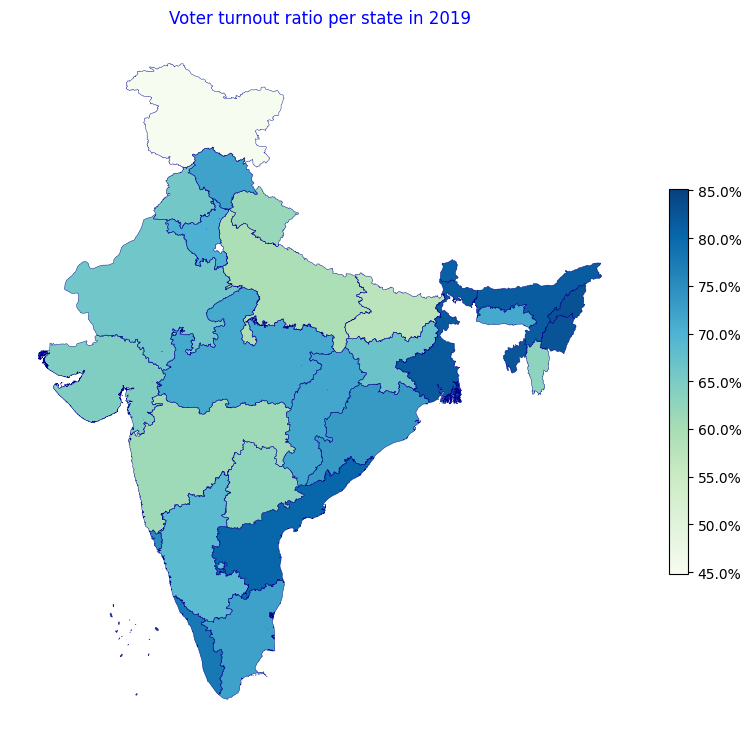

In [35]:
state_shape = gpd.read_file("states_shape/Indian_States.shp")
state_data = pd.DataFrame({"state": df.index,"tr":df["Turnout Ratio"]}).reset_index(drop = True)
final_data = pd.merge(state_data,state_shape, left_on = "state" , right_on = "st_nm")
final_data = gpd.GeoDataFrame(final_data)
ax = final_data.boundary.plot(edgecolor='darkblue', linewidth = 0.3, figsize=(10,10))
final_data.plot(ax=ax, column='tr', cmap='GnBu',
            legend=True, legend_kwds={'shrink':0.5, 'format':'%.1f%%'} )
ax.axis('off')
ax.set_title('Voter turnout ratio per state in 2019', size=12, color='blue')

plt.show()

top 5 states of 2019 in terms of voter turnout ratio.

In [36]:
df.sort_values("Turnout Ratio",ascending = False).head(5)

,total_votes,total_electors,Turnout Ratio
state,,,
Lakshadweep,47009,55189,85.18
Nagaland,1006357,1213777,82.91
Manipur,1617330,1959563,82.54
Tripura,2153172,2614718,82.35
West Bengal,57206976,70001284,81.72


bottom 5 states of 2019 in terms of voter turnout ratio.

In [37]:
df.sort_values("Turnout Ratio").head(5)

,total_votes,total_electors,Turnout Ratio
state,,,
Jammu & Kashmir,3552622,7922538,44.84
Bihar,40806661,71216290,57.30
Uttar Pradesh,86481398,146134603,59.18
NCT OF Delhi,8679012,14327649,60.58
Maharashtra,54054245,88676946,60.96


### Q 3. Which constituencies have elected the same party for 2 consecutive elections, rank them by % of votes to that winning party in 2019

In [38]:
# geting the winners of 2014 and there vote % of 2014
dt_14 = dt_2014.groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)
votes_14 = dt_2014.groupby("pc_name").total_votes.sum()
dt_14 = dt_14.merge(votes_14,on = "pc_name")[["pc_name","party","total_votes_x","total_votes_y"]].rename(columns = {"total_votes_x":"votes_receved","total_votes_y":"total_votes"})
dt_14["percentage"] = round(((dt_14["votes_receved"]/dt_14["total_votes"])*100),2)

# geting the winners of 2019 and there vote % of 2019
dt_19 = dt_2019.groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)
votes_19 = dt_2019.groupby("pc_name").total_votes.sum()
dt_19 = dt_19.merge(votes_19,on = "pc_name")[["pc_name","party","total_votes_x","total_votes_y"]].rename(columns = {"total_votes_x":"votes_receved","total_votes_y":"total_votes"})
dt_19["percentage"] = round(((dt_19["votes_receved"]/dt_19["total_votes"])*100),2)

# merging both data
df = pd.merge(dt_14,dt_19, on = "pc_name", suffixes=('_14', '_19'))

# filtering constituencies which has same parties 
df = df[df["party_14"] == df["party_19"]]

# results
data = df.rename(columns={"party_14":"party","pc_name":"constituencies"}).set_index("constituencies").sort_values("percentage_19", ascending = False).head(10)
data

,party,votes_receved_14,total_votes_14,percentage_14,party_19,votes_receved_19,total_votes_19,percentage_19
constituencies,,,,,,,,
surat,"BJP , Lotus",718412,947922,75.79,"BJP , Lotus",795651,1068412,74.47
navsari,"BJP , Lotus",820831,1160747,70.72,"BJP , Lotus",972739,1308018,74.37
vadodara,"BJP , Lotus",845464,1161577,72.79,"BJP , Lotus",883719,1222348,72.30
kangra,"BJP , Lotus",456163,799445,57.06,"BJP , Lotus",725218,1006989,72.02
bhilwara,"BJP , Lotus",630317,1104090,57.09,"BJP , Lotus",938160,1310513,71.59
mumbai north,"BJP , Lotus",664004,946562,70.15,"BJP , Lotus",706678,989759,71.40
karnal,"BJP , Lotus",594817,1193500,49.84,"BJP , Lotus",911594,1300722,70.08
gandhinagar,"BJP , Lotus",773539,1135495,68.12,"BJP , Lotus",894624,1284090,69.67
rajsamand,"BJP , Lotus",644794,982119,65.65,"BJP , Lotus",863039,1239845,69.61


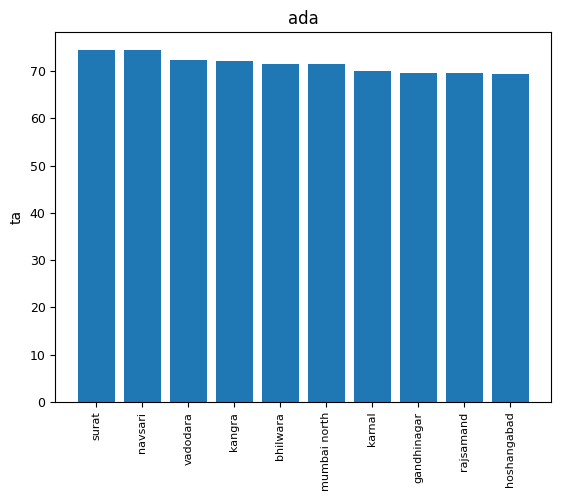

In [39]:
plt.bar(data.index,data["percentage_19"])
plt.title("ada")
plt.ylabel("ta")
plt.tick_params(axis='x', labelrotation=90, labelsize=8)
plt.tick_params(axis='y', labelsize=9)
plt.show()

There are total 333 constituencies which elected same party consecutively for second time in 2019 Loksabha elections.

### Q 4. Which constituencies have voted for different parties in two elections (list top 10 based on difference (2019-2014) in winner vote percentage in two elections).

In [40]:
# geting the winners of 2014 and there vote % of 2014
dt_14 = dt_2014.groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)
votes_14 = dt_2014.groupby("pc_name").total_votes.sum()
dt_14 = dt_14.merge(votes_14,on = "pc_name")[["pc_name","party","total_votes_x","total_votes_y"]].rename(columns = {"total_votes_x":"votes_receved","total_votes_y":"total_votes"})
dt_14["percentage"] = round(((dt_14["votes_receved"]/dt_14["total_votes"])*100),2)

# geting the winner of 2019 and there vote % of 2019
dt_19 = dt_2019.groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)
votes_19 = dt_2019.groupby("pc_name").total_votes.sum()
dt_19 = dt_19.merge(votes_19,on = "pc_name")[["pc_name","party","total_votes_x","total_votes_y"]].rename(columns = {"total_votes_x":"votes_receved","total_votes_y":"total_votes"})
dt_19["percentage"] = round(((dt_19["votes_receved"]/dt_19["total_votes"])*100),2)

# merging both data
df = pd.merge(dt_14,dt_19, on = "pc_name", suffixes=('_14', '_19'))

# filtering constituencies which has diffrent parties 
df = df[df["party_14"] != df["party_19"]][["pc_name","party_14","percentage_14","party_19","percentage_19"]]

# finding diffrence between percentage of votes of winner in 2014 and 2019.
df["vote diff"] = df["percentage_19"] - df["percentage_14"]

# result
data = df.rename(columns={"party_14":"party","pc_name":"constituencies"}).set_index("constituencies").sort_values("vote diff", ascending = False).head(10)
data

,party,percentage_14,party_19,percentage_19,vote diff
constituencies,,,,,
alipurduars,"AITC , Flowers and Grass",29.62,"BJP , Lotus",54.40,24.78
autonomous district,"INC , Hand",39.23,"BJP , Lotus",61.73,22.50
kanniyakumari,"BJP , Lotus",37.64,"INC , Hand",59.83,22.19
puducherry,"AINRC , Jug",34.57,"INC , Hand",56.27,21.70
bhagalpur,"RJD , Hurricane Lamp",37.74,"JD(U) , Arrow",59.30,21.56
sambhal,"BJP , Lotus",34.08,"SP , Bicycle",55.60,21.52
jhanjharpur,"BJP , Lotus",35.64,"JD(U) , Arrow",56.80,21.16
chikkballapur,"INC , Hand",33.63,"BJP , Lotus",53.78,20.15
ghazipur,"BJP , Lotus",31.11,"BSP , Elephant",51.20,20.09


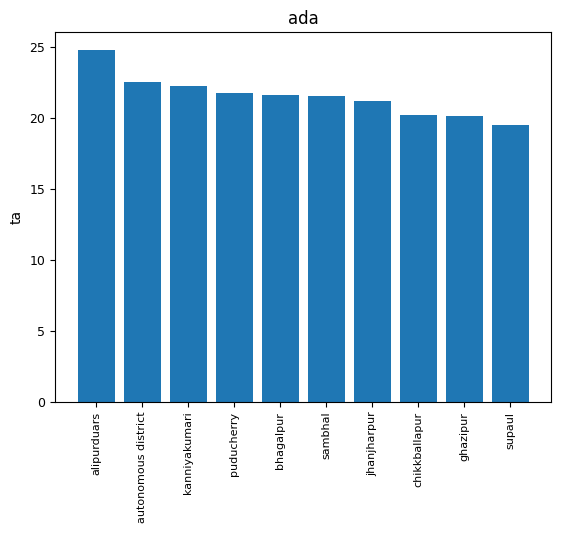

In [41]:
plt.bar(data.index,data["vote diff"])
plt.title("ada")
plt.ylabel("ta")
plt.tick_params(axis='x', labelrotation=90, labelsize=8)
plt.tick_params(axis='y', labelsize=9)
plt.show()

There are total 175 constituencies which elected different party in 2019 Loksabha elections

### Q 5. Top 5 candidates based on margin difference with runners in 2014 and 2019

In [42]:
# function to filter top candidates by margin
def rank_by_margin(data,n):
    # filter rank 1 candidates
    df1 = data[["pc_name","candidate","total_votes","party"]].groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)
    # filter rank 2 candidates
    df2 = data[["pc_name","candidate","total_votes","state","party"]].groupby("pc_name").apply(lambda x: x.sort_values("total_votes", ascending = False )[1:].head(1)).reset_index(drop=True)

    # merge dataframes to get pc_name, candidate, rank_1_votes, rank_2_votes, margin
    df = pd.merge(df1,df2, on = "pc_name", suffixes=('_f', '_s'))

    # column to show margin
    df["margin"] = df["total_votes_f"] - df["total_votes_s"]

    # top 5 winners by margin 
    df = df.sort_values(by = "margin",ascending = False)[["state","pc_name","candidate_f","party_f","total_votes_f","candidate_s","party_s","total_votes_s","margin"]]

    return df.rename(columns={"pc_name":"constituencies","candidate_f":"candidate","party_f":"candidate party","total_votes_f":"candidate total votes","candidate_s":"runner","party_s":"runner party","total_votes_s":"runner total votes"}).set_index("state").head(n)

In [43]:
# # Top 5 candidates based on margin with runners in 2014
rank_by_margin(dt_2014,5)

,constituencies,candidate,candidate party,candidate total votes,runner,runner party,runner total votes,margin
state,,,,,,,,
Gujarat,vadodara,NARENDRA MODI,"BJP , Lotus",845464,MISTRI MADHUSUDAN DEVRAM,"INC , Hand",275336,570128
Uttar Pradesh,ghaziabad,VIJAY KUMAR SINGH,"BJP , Lotus",758482,RAJ BABBAR,"INC , Hand",191222,567260
Gujarat,navsari,C. R. PATIL,"BJP , Lotus",820831,MAKSUD MIRZA,"INC , Hand",262715,558116
Rajasthan,jaipur,RAMCHARAN BOHARA,"BJP , Lotus",863358,DR. MAHESH JOSHI,"INC , Hand",324013,539345
Gujarat,surat,DARSHANA VIKRAM JARDOSH,"BJP , Lotus",718412,DESAI NAISHADHBHAI BHUPATBHAI,"INC , Hand",185222,533190


In [44]:
# # Top 5 candidates based on margin with runners in 2019
rank_by_margin(dt_2019,5)

,constituencies,candidate,candidate party,candidate total votes,runner,runner party,runner total votes,margin
state,,,,,,,,
Gujarat,navsari,C. R. Patil,"BJP , Lotus",972739,PATEL DHARMESHBHAI BHIMBHAI,"INC , Hand",283071,689668
Haryana,karnal,Sanjay Bhatia,"BJP , Lotus",911594,Kuldip Sharma,"INC , Hand",255452,656142
Haryana,faridabad,KRISHAN PAL,"BJP , Lotus",913222,AVTAR SINGH BHADANA,"INC , Hand",274983,638239
Rajasthan,bhilwara,SUBHASH CHANDRA BAHERIA,"BJP , Lotus",938160,RAM PAL SHARMA,"INC , Hand",326160,612000
Gujarat,vadodara,RANJANBEN BHATT,"BJP , Lotus",883719,PRASHANT PATEL (TIKO),"INC , Hand",294542,589177


### Q 6. % split of votes of parties between 2014 vs 2019 at national level

In [45]:
# preparing all data for 2014 and 2015
df_14 = dt_2014.groupby("party")["total_votes"].sum().reset_index()
df_19 = dt_2019.groupby("party")["total_votes"].sum().reset_index()

total_vote_14 = dt_2014["total_votes"].sum()
total_vote_19 = dt_2019["total_votes"].sum()

df_14["% votes"] = ((df_14["total_votes"] / total_vote_14)*100)
df_19["% votes"] = ((df_19["total_votes"] / total_vote_19)*100)

Top 10 parties with highest vote share % 2014

In [46]:
df_14.sort_values("% votes", ascending = False).head(10)

,party,total_votes,% votes
121,"BJP , Lotus",161047761,30.969622
247,"INC , Hand",96641749,18.584291
160,"BSP , Elephant",22434033,4.314084
46,"AITC , Flowers and Grass",21215661,4.079790
691,"SP , Bicycle",18623266,3.581270
28,"ADMK , Two Leaves",18111579,3.482872
185,"CPM , Hammer, Sickle and Star",17938138,3.449519
726,"TDP , Bicycle",14099230,2.711294
757,"YSRCP , Ceiling Fan",13995435,2.691334
1,"AAAP , Broom",11036817,2.122389


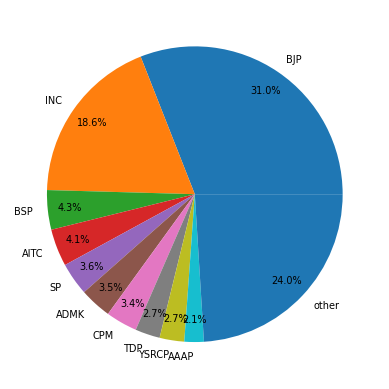

In [47]:
num = 10

df_14 = df_14[["party","% votes"]].set_index("party")

data = df_14[df_14.index != "NOTA , NOTA"].sort_values("% votes",ascending = False)

data2 = df_14[df_14.index == "NOTA , NOTA"].values

final_dt = data[:num].copy()

final_dt.loc["other"] = data[num:].sum() 

final_dt.loc["other"] = final_dt.loc["other"].values + data2

plt.pie(final_dt["% votes"] , labels = final_dt.index.str.split(" , ").str[0] , autopct='%1.1f%%', pctdistance=0.85 , textprops={'fontsize': 7})
plt.show()

Top 10 parties with highest vote share % 2019

In [48]:
df_19.sort_values("% votes", ascending = False).head(10)

,party,total_votes,% votes
171,"BJP , Lotus",229076879,37.298440
325,"INC , Hand",119495214,19.456285
59,"AITC , Flowers and Grass",24929330,4.059009
232,"BSP , Elephant",22246501,3.622189
1017,"SP , Bicycle",15636617,2.545964
1125,"YSRCP , Ceiling Fan",15537006,2.529745
272,"DMK , Rising Sun",14363332,2.338647
1068,"TDP , Bicycle",12515345,2.037756
992,"SHS , Bow and Arrow",12195761,1.985721
259,"CPIM , Hammer, Sickle and Star",10744908,1.749493


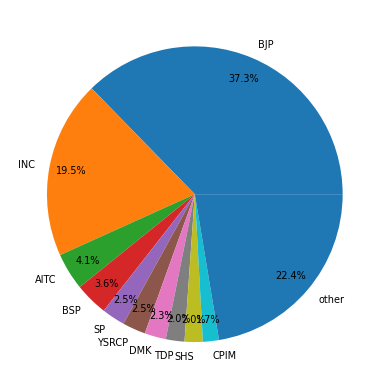

In [49]:
num = 10

df_19 = df_19[["party","% votes"]].set_index("party")

data = df_19[df_19.index != "NOTA , NOTA"].sort_values("% votes",ascending = False)

data2 = df_19[df_19.index == "NOTA , NOTA"].values

final_dt = data[:num].copy()

final_dt.loc["other"] = data[num:].sum() 

final_dt.loc["other"] = final_dt.loc["other"].values + data2

plt.pie(final_dt["% votes"] , labels = final_dt.index.str.split(" , ").str[0] , autopct='%1.1f%%', pctdistance=0.85 , textprops={'fontsize': 7})
plt.show()

### Q 7. % split of votes of parties between 2014 vs 2019 at state level

For 2014

In [50]:
# preparing all data for 2014 
states = dt_2014.groupby("state").pc_name.nunique().sort_values(ascending = False).head().index

In [51]:
# vairables for for loop.
dt = dt_2014
num = 5

In [52]:
# Get breakdown for top 5 states having highest number of constituencies
for x in states:
    y = dt[dt["state"] == x][["party","total_votes"]].groupby("party").sum()
    data = y[y.index != "NOTA , NOTA"].sort_values("total_votes",ascending = False)
    data2 = y[y.index == "NOTA , NOTA"].values
    final_dt = data[:num].copy()
    final_dt.loc["other"] = data[num:].sum() 
    final_dt.loc["other"] = final_dt.loc["other"].values + data2
    total = final_dt.sum().values
    print(x)
    print(((final_dt["total_votes"]/total)*100),"\n\n\n")

Uttar Pradesh
party
BJP , Lotus       42.320303
SP , Bicycle      22.183099
BSP , Elephant    19.624592
INC , Hand         7.474453
AAAP , Broom       1.012789
other              7.384765
Name: total_votes, dtype: float64 



Maharashtra
party
BJP , Lotus          27.318691
SHS , Bow & Arrow    20.630510
INC , Hand           18.125324
NCP , Clock          15.974317
BSP , Elephant        2.610319
other                15.340839
Name: total_votes, dtype: float64 



West Bengal
party
AITC , Flowers and Grass         39.348330
CPM , Hammer, Sickle and Star    22.705309
BJP , Lotus                      16.835153
INC , Hand                        9.581127
RSP , Spade & Stoker              2.432209
other                             9.097873
Name: total_votes, dtype: float64 



Bihar
party
BJP , Lotus             29.379762
RJD , Hurricane Lamp    20.133276
JD(U) , Arrow           15.779272
INC , Hand               8.418663
LJP , Bungalow           6.397959
other                   19.891069
Na

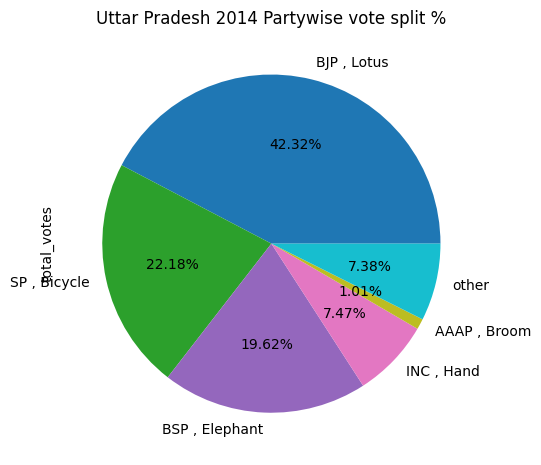

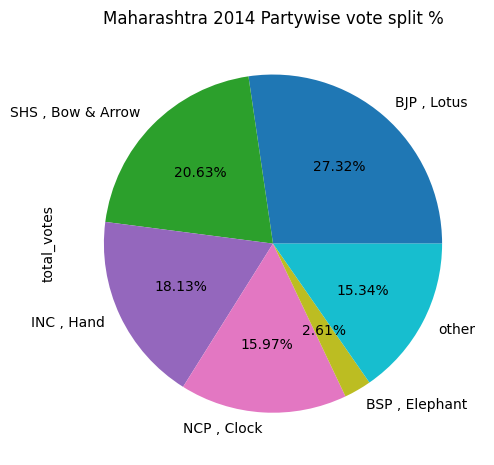

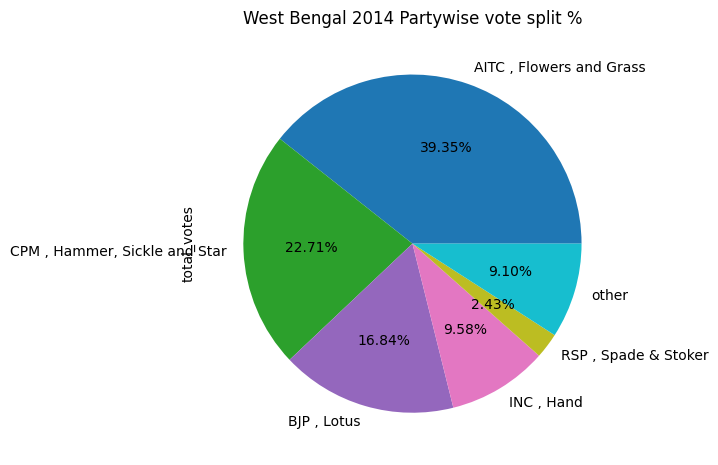

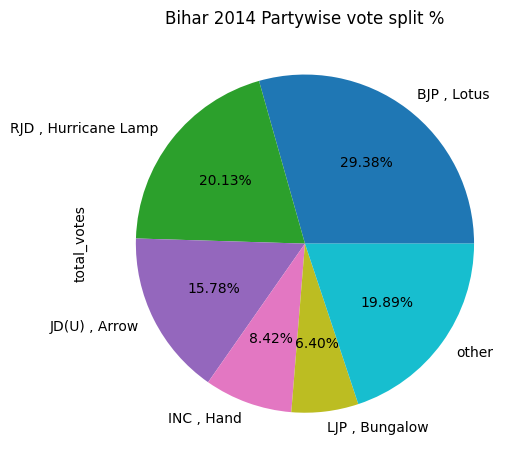

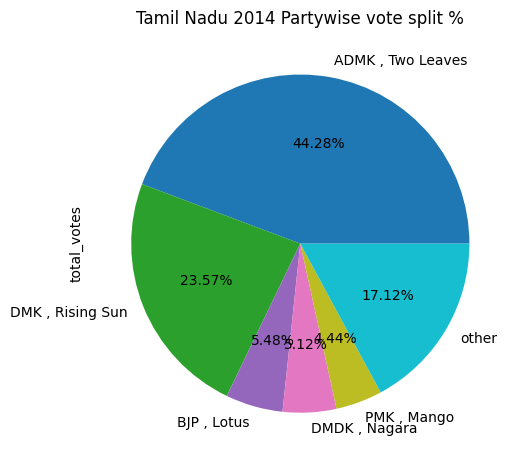

In [53]:
# Plot top 5 parties in each state
for x in states:
    y = dt[dt["state"] == x][["party","total_votes"]].groupby("party").sum()
    data = y[y.index != "NOTA , NOTA"].sort_values("total_votes",ascending = False)
    data2 = y[y.index == "NOTA , NOTA"].values
    final_dt = data[:num].copy()
    final_dt.loc["other"] = data[num:].sum() 
    final_dt.loc["other"] = final_dt.loc["other"].values + data2
    total = final_dt.sum().values
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    ((final_dt["total_votes"]/total)*100).plot(kind="pie", autopct="%.2f%%", cmap='tab10')
    plt.title(f"{x} 2014 Partywise vote split %")

In [54]:
# vairables for for loop.
dt = dt_2019
num = 5

In [55]:
# Get breakdown for top 5 states having highest number of constituencies
for x in states:
    y = dt[dt["state"] == x][["party","total_votes"]].groupby("party").sum()
    data = y[y.index != "NOTA , NOTA"].sort_values("total_votes",ascending = False)
    data2 = y[y.index == "NOTA , NOTA"].values
    final_dt = data[:num].copy()
    final_dt.loc["other"] = data[num:].sum() 
    final_dt.loc["other"] = final_dt.loc["other"].values + data2
    total = final_dt.sum().values
    print(x)
    print(((final_dt["total_votes"]/total)*100),"\n\n\n")

Uttar Pradesh
party
BJP , Lotus        49.557676
BSP , Elephant     19.263974
SP , Bicycle       17.961805
INC , Hand          6.310435
RLD , Hand Pump     1.673612
other               5.232499
Name: total_votes, dtype: float64 



Maharashtra
party
BJP , Lotus            27.587360
SHS , Bow and Arrow    22.503600
INC , Hand             16.265581
NCP , Clock            15.516567
VBA , Cup & Saucer      5.887358
other                  12.239535
Name: total_votes, dtype: float64 



West Bengal
party
AITC , Flowers and Grass          43.276794
BJP , Lotus                       40.254736
CPIM , Hammer, Sickle and Star     6.282945
INC , Hand                         5.612062
AIFB , Lion                        0.418327
other                              4.155137
Name: total_votes, dtype: float64 



Bihar
party
BJP , Lotus             23.573475
JD(U) , Arrow           21.816828
RJD , Hurricane Lamp    15.367023
LJP , Bungalow           7.858960
INC , Hand               7.696775
other       

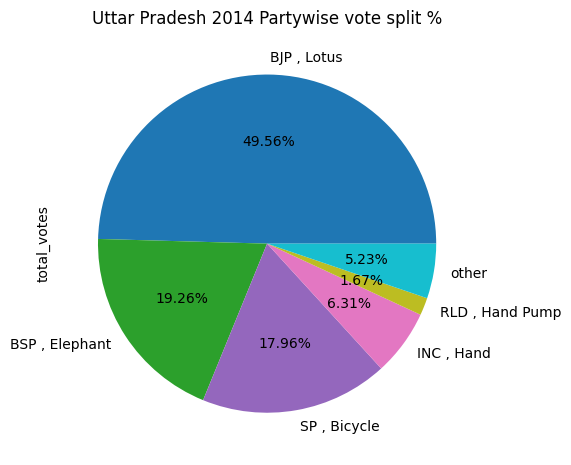

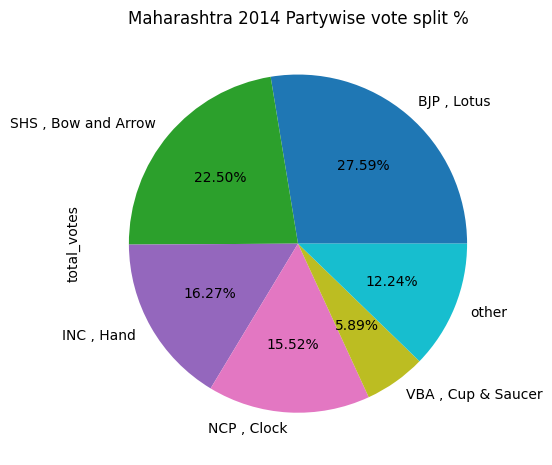

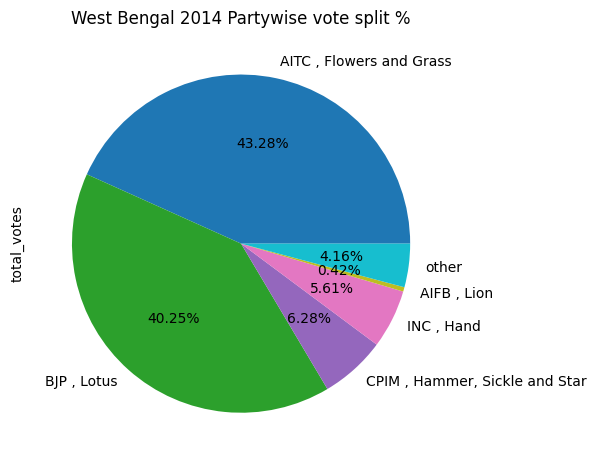

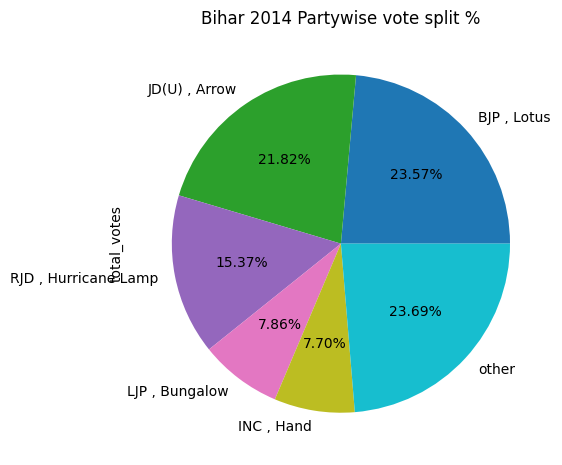

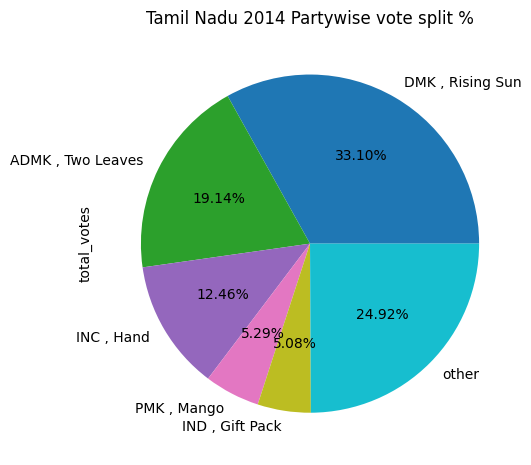

In [56]:
# Plot top 5 parties in each state
for x in states:

    y = dt[dt["state"] == x][["party","total_votes"]].groupby("party").sum()

    data = y[y.index != "NOTA , NOTA"].sort_values("total_votes",ascending = False)

    data2 = y[y.index == "NOTA , NOTA"].values

    final_dt = data[:num].copy()

    final_dt.loc["other"] = data[num:].sum() 

    final_dt.loc["other"] = final_dt.loc["other"].values + data2

    total = final_dt.sum().values
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    ((final_dt["total_votes"]/total)*100).plot(kind="pie", autopct="%.2f%%", cmap='tab10')
    plt.title(f"{x} 2014 Partywise vote split %")

### Q 8. List top 5 constituencies for two major national parties where they have gained vote share in 2019 as compared to 2014

In [57]:
# to find top 2 parties
top_parties = list(dt_2014.groupby("party")["total_votes"].sum().sort_values(ascending = False).head(2).index)

# collecting there data for 2014 and 2019
df_14 = dt_2014[dt_2014["party"].isin(top_parties)].groupby(["pc_name","party"])["total_votes"].sum().reset_index()
df_19 = dt_2019[dt_2019["party"].isin(top_parties)].groupby(["pc_name","party"])["total_votes"].sum().reset_index()

# grouping and merging
total_vote_14 = dt_2014.groupby("pc_name")["total_votes"].sum()
total_vote_19 = dt_2019.groupby("pc_name")["total_votes"].sum()
df_14 = pd.merge(df_14 , total_vote_14, on = "pc_name", suffixes = ("_p","_s"))
df_19 = pd.merge(df_19 , total_vote_19, on = "pc_name", suffixes = ("_p","_s"))

# calculating vote % for both years
df_14["% votes"] = ((df_14["total_votes_p"] / df_14["total_votes_s"])*100)
df_19["% votes"] = ((df_19["total_votes_p"] / df_19["total_votes_s"])*100)

# merge both data
final_dt = pd.merge(df_14,df_19, on = ["pc_name","party"], suffixes = ("_14","_19"), how = "inner")

# calculating change
final_dt["change_in_vote_share_%"] = final_dt["% votes_19"] - final_dt["% votes_14"]

# final data
final_dt = final_dt.groupby("party").apply(lambda x: x.sort_values("change_in_vote_share_%", ascending = False ).head(5)).reset_index(drop=True)
print(" top 5 constituencies for two major national parties where they have gained vote share in 2019 as compared to 2014.")
final_dt[["party","pc_name","% votes_14","% votes_19","change_in_vote_share_%"]].set_index("pc_name").rename(columns = {"% votes_14":"% votes in 2014","% votes_19":"% votes in 2019"})

 top 5 constituencies for two major national parties where they have gained vote share in 2019 as compared to 2014.


,party,% votes in 2014,% votes in 2019,change_in_vote_share_%
pc_name,,,,
tripura west,"BJP , Lotus",5.099609,51.774264,46.674656
purulia,"BJP , Lotus",7.158445,49.298203,42.139758
tripura east,"BJP , Lotus",6.373071,46.118056,39.744986
ranaghat,"BJP , Lotus",17.268008,52.778607,35.510598
jhargram,"BJP , Lotus",9.737415,44.558154,34.820739
karur,"INC , Hand",2.910464,63.063730,60.153266
tiruchirappalli,"INC , Hand",5.214976,59.279413,54.064437
arani,"INC , Hand",2.528817,54.004390,51.475573
thiruvallur,"INC , Hand",3.504353,54.487856,50.983504


### Q 9. List top 5 constituencies for two major national parties where they have lost vote share in 2019 as compared to 2014

In [58]:
# to find top 2 parties
top_parties = list(dt_2014.groupby("party")["total_votes"].sum().sort_values(ascending = False).head(2).index)

# collecting there data for 2014 and 2019
df_14 = dt_2014[dt_2014["party"].isin(top_parties)].groupby(["pc_name","party"])["total_votes"].sum().reset_index()
df_19 = dt_2019[dt_2019["party"].isin(top_parties)].groupby(["pc_name","party"])["total_votes"].sum().reset_index()

# grouping and merging
total_vote_14 = dt_2014.groupby("pc_name")["total_votes"].sum()
total_vote_19 = dt_2019.groupby("pc_name")["total_votes"].sum()
df_14 = pd.merge(df_14 , total_vote_14, on = "pc_name", suffixes = ("_p","_s"))
df_19 = pd.merge(df_19 , total_vote_19, on = "pc_name", suffixes = ("_p","_s"))

# calculating vote % for both years
df_14["% votes"] = ((df_14["total_votes_p"] / df_14["total_votes_s"])*100)
df_19["% votes"] = ((df_19["total_votes_p"] / df_19["total_votes_s"])*100)

# merge both data
final_dt = pd.merge(df_14,df_19, on = ["pc_name","party"], suffixes = ("_14","_19"), how = "inner")

# calculating change
final_dt["change_in_vote_share_%"] = final_dt["% votes_19"] - final_dt["% votes_14"]

# final data
final_dt = final_dt.groupby("party").apply(lambda x: x.sort_values( by = "change_in_vote_share_%").head(5)).reset_index(drop=True)
print("top 5 constituencies for two major national parties where they have lost vote share in 2019 as compared to 2014.")
final_dt[["party","pc_name","% votes_14","% votes_19","change_in_vote_share_%"]].set_index("pc_name").rename(columns = {"% votes_14":"% votes in 2014","% votes_19":"% votes in 2019"})

top 5 constituencies for two major national parties where they have lost vote share in 2019 as compared to 2014.


,party,% votes in 2014,% votes in 2019,change_in_vote_share_%
pc_name,,,,
narsapuram,"BJP , Lotus",49.617291,1.054054,-48.563236
visakhapatnam,"BJP , Lotus",48.715406,2.733768,-45.981638
tirupati,"BJP , Lotus",44.758718,1.227622,-43.531096
sangli,"BJP , Lotus",58.430014,42.774199,-15.655815
daman & diu,"BJP , Lotus",53.832838,42.983228,-10.849610
dadra and nagar haveli,"INC , Hand",45.119369,4.325998,-40.793371
ratnagiri sindhudurg,"INC , Hand",38.274444,7.024621,-31.249823
aurangabad (Maharashtra),"INC , Hand",36.513374,7.660440,-28.852934
arunachal west,"INC , Hand",38.022731,14.220368,-23.802363


### Q 10. Which constituency has voted the most for nota?

In [59]:
# create a function to filter constituencies having highest Nota vote share %
def top_NOTA(dt):
    data = dt[dt["party"] == "NOTA , NOTA"][["state","pc_name","total_votes"]]

    return data.sort_values(by = "total_votes", ascending = False).rename(columns = {"pc_name":"constituencies"}).set_index("state").head(5)

In [60]:
# highest nota % constituencies in 2014 
print("constituency which has voted the most for NOTA in 2014.")
top_NOTA(dt_2014)

constituency which has voted the most for NOTA in 2014.


,constituencies,total_votes
state,,
Tamil Nadu,nilgiris,46559
Rajasthan,banswara,34404
Gujarat,dahod,32305
Madhya Pradesh,ratlam,30364
Bihar,samastipur,29211


In [61]:
# highest nota constituencies in 2019
print("constituency which has voted the most for NOTA in 2019")
top_NOTA(dt_2019)

constituency which has voted the most for NOTA in 2019


,constituencies,total_votes
state,,
Bihar,gopalganj,51660
Andhra Pradesh,aruku,47977
Bihar,paschim champaran,45699
Odisha,nabarangpur,44582
Chhattisgarh,bastar,41667


### Q 11. Which constituencies have elected candidates whose party has less than 10% vote share at state level in 2019?

In [62]:
# making groups of parties
df_19 = dt_2019.groupby(["state","party"])["total_votes"].sum().reset_index()

# making groups of states
total_vote_19 = dt_2019.groupby("state")["total_votes"].sum()

# merging both data
df_19 = pd.merge(df_19 , total_vote_19, on = "state", suffixes = ("_p","_s"))

# calculating vote %
df_19["% votes"] = ((df_19["total_votes_p"] / df_19["total_votes_s"])*100)

# finding the winner
df1 = dt_2019[["state","pc_name","candidate","total_votes","party"]].groupby("pc_name").apply(lambda x: x.loc[x["total_votes"].idxmax()]).reset_index(drop=True)

# extracting data of all the winner 
finaldf = pd.merge(df_19[["state","party","% votes"]], df1[["state","pc_name","candidate","party"]], on = ["state","party"], suffixes = ("_p","_s"))

# final data
print("constituencies which have elected candidates whose party has less than 10% vote share at state level in 2019")
finaldf[finaldf["% votes"] <= 10][["pc_name","candidate","party","% votes"]].rename(columns = {"pc_name":"constituencies"}).set_index("constituencies").sort_values("% votes")

constituencies which have elected candidates whose party has less than 10% vote share at state level in 2019


,candidate,party,% votes
constituencies,,,
aurangabad (Maharashtra),Imtiaz Jaleel Syed,"AIMIM , Kite",0.719725
mumbai south central,Rahul Ramesh Shewale,"SHS , Bow & Arrow",0.786086
amravati,Navnit Ravi Rana,"IND , Spanner",0.946089
ramanathapuram,K. NAVASKANI,"IUML , Ladder",1.082996
chidambaram,THIRUMAAVALAVAN THOL,"VCK , Pot",1.152790
robertsganj,PAKAURI LAL KOL,"ADAL , Cup & Saucer",1.201967
mirzapur,Anupriya Singh Patel,"ADAL , Cup & Saucer",1.201967
nagaur,HANUMAN BENIWAL,"RLTP , Tyres",2.034616
mandya,SUMALATHA AMBAREESH,"IND , Man Blowing Turha",2.049371
